## RT in spherical coordinates, assuming spherical symmetry and static case

In this notebook I tested how to solve the ODE in the spherically symmetric case. For constant a and j there is an analytic solution which I implemented first. Additionally I implemented a numeric solution via diffrax to check if this leads to the same result. 

</b>

Afterwards I defined a function that solves the ODE for a and j being a function of r. 

</b>

The method `create_data_spherical_symmetry` in the last section is a generalization of this. It calculates the solution for I(r) for multiple defined scenarios (r0, r1, I0)

In [12]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Callable
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

### Solutions for constant a and j (a(r)= const, j(r) = const)

#### Analytic solution of ODE

In [2]:
def rte_spherical_symmetry(r,a,j,I0, r0):
    return (I0 - j/a + 2*j/a**2 * 1/r0) * r0/jnp.exp(-a/2 * r0) * jnp.exp(-a/2 * r)/r + j/a -2*j/a**2 * 1/r
 

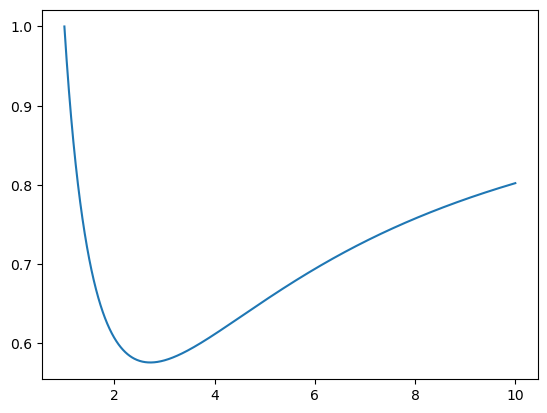

In [3]:
r_line = jnp.linspace(1, 10, 1000)
I = rte_spherical_symmetry(r_line, 1, 1, 1, 1)

plt.plot(r_line, I) 
plt.show()

#### Solve ODE with Diffrax

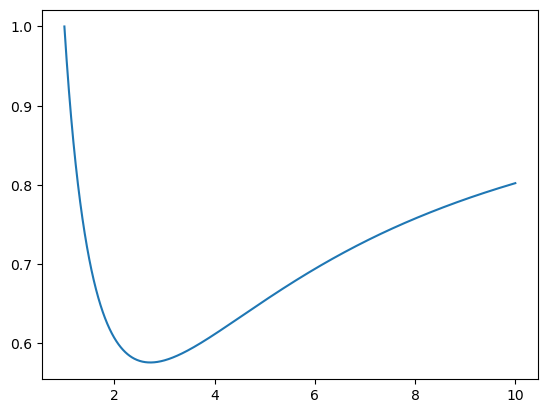

In [4]:

def rt_spherical_symmetry_ode(r, I, args):
    a,j = args[0], args[1]
    return -(a/2 + 1/r)*I +j/2


I0 = 1.
r0 = 1.
r1 = 10.
a = 1.
j = 1.
params = (a,j)

r_values =  SaveAt(ts=jnp.linspace(1, 10, 1000))

term = ODETerm(rt_spherical_symmetry_ode)
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(term, solver, t0=r0, t1=r1, dt0=0.1, y0=I0,
                  stepsize_controller=stepsize_controller, args = params, saveat= r_values)

#print(sol.ts)  
#print(sol.ys)  


plt.plot(sol.ts, sol.ys)
plt.show()


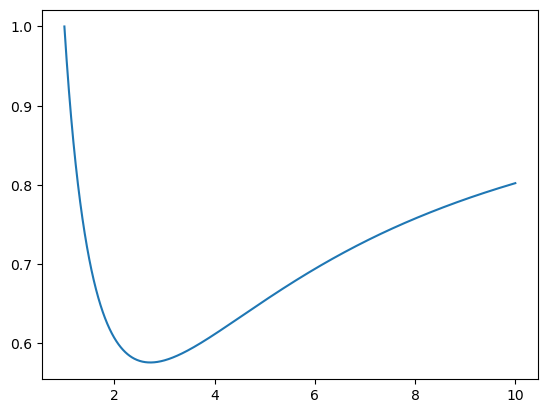

In [5]:
#same integration but now with non-constant a and j (a = a(r), j = j(r))

def absorption(r):
    return 1. #to create data for different scenarios I will change this to a function of r

def emission(r):
    return 1.  #to create data for different scenarios I will change this to a function of r


def rt_spherical_symmetry_ode(r, I, args):
    a = absorption(r)
    j = emission(r)
    return -(a/2 + 1/r)*I +j/2


I0 = 1.
r0 = 1.
r1 = 10.


r_values =  SaveAt(ts=jnp.linspace(1, 10, 1000))

term = ODETerm(rt_spherical_symmetry_ode)
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(term, solver, t0=r0, t1=r1, dt0=0.1, y0=I0,
                  stepsize_controller=stepsize_controller, saveat= r_values)


plt.plot(sol.ts, sol.ys)
plt.show()


## Create training data

In [6]:
#Funktion definieren, die oberhalb definiertes nutzt um Trainingsdaten für verschiedene Szenarien zu definieren (verschiedene Werte für a,j, ..)
#eventuell auch implementieren, dass a, j nicht const sind, dafür brauche ich dann aber numerische Integration (in neuer Funktion definieren)
# + auch Schritt/grid größe vllt Parameter 

#unbedingt für a und j als Funktionen von r noch implementieren (numerische Integration) (+ evtl. mal interessehalber schauen ob auch analytisch möglich)

In [35]:
def absorption(r):
    return 1. #to create data for different scenarios I will change this to a function of r

def emission(r):
    return 1.  #to create data for different scenarios I will change this to a function of r

def rt_spherical_symmetry_ode(r, I, args):  #args has to be there even if it isn't used 
    a = args[0](r)
    j = args[1](r)
    return -(a/2 + 1/r)*I +j/2



def create_data_spherical_symmetry(
        r_min: jnp.ndarray, 
        r_max: jnp.ndarray, 
        I0: jnp.ndarray, 
        stepsize: jnp.ndarray, 
        a: Callable[[jnp.ndarray], jnp.ndarray], 
        j: Callable[[jnp.ndarray], jnp.ndarray]):
    
    
    solver = Dopri5()
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    term = ODETerm(rt_spherical_symmetry_ode)
        
    def solve_one(r0, r1, I_start):
        r_values =  SaveAt(ts=jnp.linspace(r0, r1, 1000)) #wenn saveat immer zwischen bestimmten Werten sein soll unabhängig von r0 und r1, den Teil hier noch ändern (checken, ob das noch geht wenn Starting condition nicht am Anfang des Intervalls)
        sol = diffeqsolve(term, solver, t0=r0, t1=r1, dt0=stepsize, y0=I_start,  
                          stepsize_controller=stepsize_controller, saveat=r_values, args=(a,j))   
        return sol.ts, sol.ys
        
    batched_solve = jax.vmap(solve_one, in_axes=(0, 0, 0))
    all_rs, all_Is = batched_solve(r_min, r_max, I0)
    all_rs = all_rs[:, jnp.newaxis, :]
    all_Is = all_Is[:, jnp.newaxis, :]
    all_data = jnp.concatenate((all_rs, all_Is), axis=1)

    return all_data   





In [36]:
# arrays for different starting values -> keep in mind to not use r0 = 0
r0s = jnp.array([1.0, 2.0, 3.0])
r1s = jnp.array([5.0, 6.0, 7.0])
I0s = jnp.array([1.0, 2.0, 3.0])

training_data = create_data_spherical_symmetry(r0s, r1s, I0s, 0.1, absorption, emission)

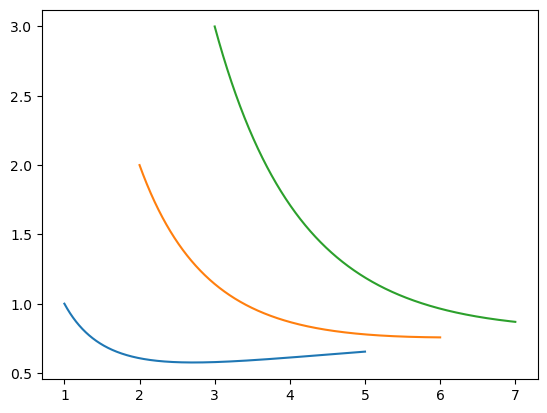

In [37]:
for i in range(len(training_data)):
    plt.plot(training_data[i][0], training_data[i][1])